# Gram continuation algorithm

This notebook implements the Gram-Fourier continuation algorithm (first developed by Lyon and Bruno (https://doi.org/10.1016/j.jcp.2009.11.020, https://doi.org/10.1016/j.jcp.2010.01.006) and later used in parallelised PDE solvers for instance by Albin and Bruno (https://doi.org/10.1121/1.4742722, https://doi.org/10.1016/j.jcp.2011.04.023).
This notebook uses the arbitrary floating point precision library mpmath instead of symbolic computations. 
It implements the Gram-Schmidt orthogonalisation algorithm and computes the left and right orthogonal polynomial basis.
It then uses the mpmath's SVD algorithm to compute accurate continuations of the Gram polynomials that are stored in binary files. 
- Step 1: Obtain orthonormal bases of Gram polynomials on the boundaries
- Step 2: Function approximation via projection
- Step 3: Compute FC(SVD) continuations for even and odd pairs of Gram polynomials

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import mpmath as mp


mp.dps = 128
eps = 1e-64

import matplotlib as mpl

plt.style.use('dark_background')

# Define your custom colors
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
    '#FF00FF',  # magenta
    '#FFA500',  # orange
    '#00FFFF',  # cyan
]

# Set the custom color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

### Step 1: Obtain orthonormal bases of Gram polynomials on the boundaries

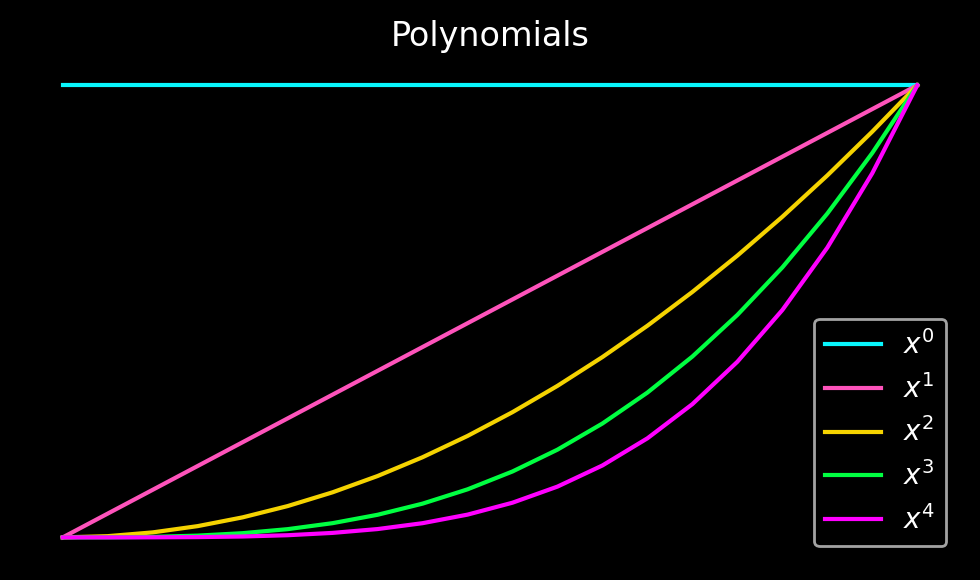

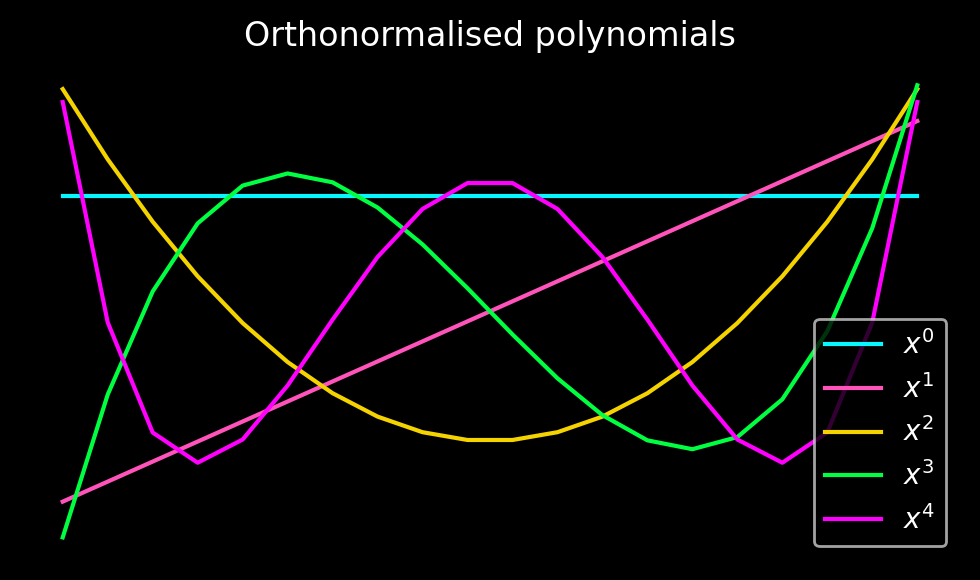

The orthonormalised polynomials and their scalar products
i = 0 u_ij = [1.0  1.73777390727309e-16  3.10316769155909e-17  -2.45150247633168e-15  1.26748884361731e-14]
i = 1 u_ij = [1.73777390727309e-16  1.0  3.94958503412367e-16  -2.76460821601527e-15  6.36322893790623e-15]
i = 2 u_ij = [3.10316769155909e-17  3.94958503412367e-16  1.0  7.39796450210107e-16  -1.16832773198625e-14]
i = 3 u_ij = [-2.45150247633168e-15  -2.76460821601527e-15  7.39796450210107e-16  1.0  -9.64614045505522e-16]
i = 4 u_ij = [1.26748884361731e-14  6.36322893790623e-15  -1.16832773198625e-14  -9.64614045505522e-16  1.0]


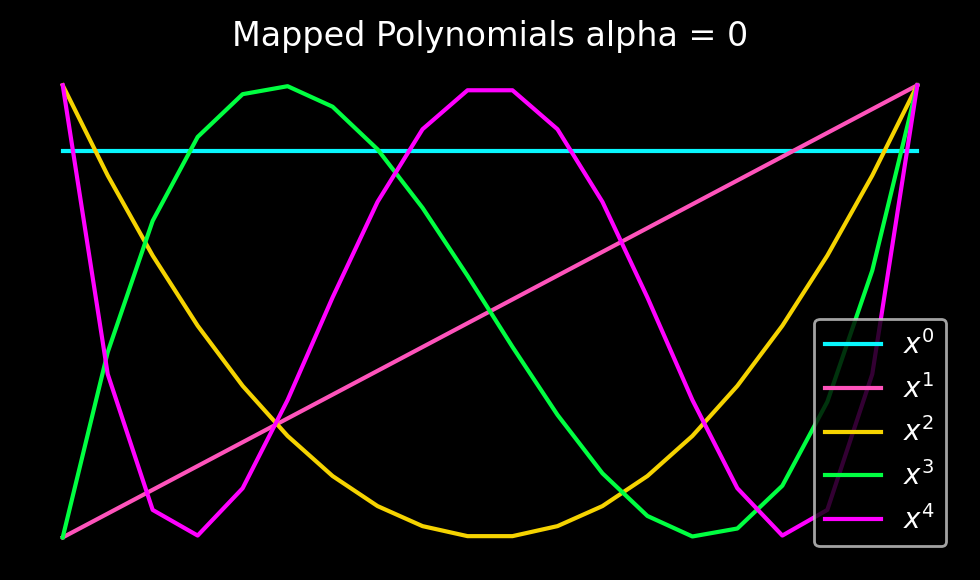

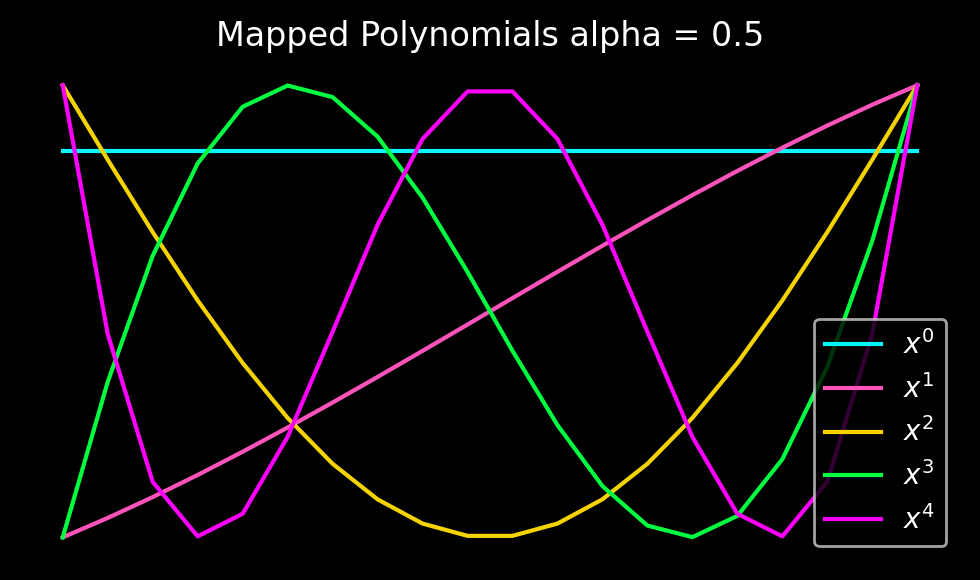

In [41]:
class GramSchmidt:
    def __init__(self, x, m):
        self.x = x
        self.m = m
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m):
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modified_gram_schmidt_algorithm(self.V)

    def evaluate_basis(self, x, basis_element_index):
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m):
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element_index].T * A

        return ei

    def scalar_product(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def project_u_onto_v(self, u, v):
        a1 = self.scalar_product(v, u)
        a2 = self.scalar_product(u, u)
        return a1/a2 * u

    def norm(self, u):
        return mp.sqrt(self.scalar_product(u, u))

    def modified_gram_schmidt_algorithm(self, V):
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0])

        for i in range(1, k):
            for j in range(i, k):
                U[:, j] = U[:, j] - self.project_u_onto_v(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def project_f_onto_basis(self, f):
        coeffs = mp.matrix(1, self.m)

        for i in range(self.m):
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs

    def reconstruct_f(self, coeffs, x = None):
        if x == None:
            A_temp = self.A
        else:
            A_temp = mp.zeros(self.m, len(x))
            for i in range(self.m):
                for j in range(len(x)):
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    A_temp[i, j] = x[j]**i

        frec = mp.matrix(1, A_temp.cols)
        for i in range(self.m):
            frec += coeffs[0, i] * (self.U[:, i].T * A_temp)
        return frec

    def plot_polynomials(self):
        m = self.m
        u_ij = mp.zeros(m)


        fig, axs = plt.subplots(figsize=(5, 3), dpi=200)
        plt.title(f"Polynomials")
        plt.axis("off")
        for i in range(m):
            plt.plot(x, self.V[:, i].T * self.A, label=f"$x^{i}$")
        plt.legend()
        plt.tight_layout()
        plt.savefig("figures/gramfe_polynomials.png", bbox_inches='tight')
        plt.show()




        fig, axs = plt.subplots(figsize=(5, 3), dpi=200)
        plt.title(f"Orthonormalised polynomials")
        plt.axis("off")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"$x^{i}$")
        plt.legend()
        plt.tight_layout()
        plt.savefig("figures/gramfe_orthonormal_polynomials.png", bbox_inches='tight')
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.scalar_product(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")

class MappedPolynomials:
    def __init__(self, x, m, alpha=0.5):
        self.x  = x
        self.x0 = x[0]
        self.L  = x[-1] - x[0]

        self.m = m
        self.alpha = alpha
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m):
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = self.phi_n(x[j], i, self.alpha)


    # Define the mapping function
    def mapping(self, x, alpha):
        x_norm = (x - self.x0) / self.L * 2 - 1
        return mp.sin(alpha * mp.pi * x_norm / 2) / mp.sin(alpha * mp.pi / 2)

    # Define the function to compute weights μm
    def compute_weights(self, zm, alpha):
        mu = mp.matrix(len(zm), 1)
        for n in range(len(zm)):
            if n == 0:
                mu[n] = (1/2) * (mp.asin(self.mapping(zm[n+1], alpha)) - mp.asin(self.mapping(zm[n], alpha)))
            elif n == len(zm) - 1:
                mu[n] = (1/2) * (mp.asin(self.mapping(zm[n], alpha)) - mp.asin(self.mapping(zm[n-1], alpha)))
            else:
                mu[n] = (1/2) * (mp.asin(self.mapping(zm[n+1], alpha)) - mp.asin(self.mapping(zm[n-1], alpha)))
        return mu

    # Define the basis functions φn(x)
    def phi_n(self, x, n, alpha):
        cn = mp.sqrt(1/mp.pi) if n == 0 else mp.sqrt(2/mp.pi)
        return cn * mp.cos(n * mp.acos(self.mapping(x, alpha)))

    def evaluate_basis(self, x, basis_element_index):
        #Linear map for polynomial scalar product
        A = mp.zeros(1, len(x))
        for j in range(len(x)):
            #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
            A[0, j] = self.phi_n(x[j], basis_element_index, self.alpha)
        return A

    def reconstruct_f(self, coeffs, x = None):
        if x == None:
            A_temp = self.A
        else:
            A_temp = mp.zeros(self.m, len(x))
            for i in range(self.m):
                for j in range(len(x)):
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    A_temp[i, j] = self.phi_n(x[j], i, self.alpha)

        frec = mp.matrix(1, A_temp.cols)
        for i in range(self.m):
            frec += coeffs[0, i] * A_temp
        return frec

    def plot_polynomials(self):
        m = self.m
        u_ij = mp.zeros(m)


        fig, axs = plt.subplots(figsize=(5, 3), dpi=200)
        plt.title(f"Mapped Polynomials alpha = 0")
        plt.axis("off")
        for i in range(m):
            plt.plot(x, [self.phi_n(_x, i, alpha=0.001) for _x in x], label=f"$x^{i}$")
        plt.legend()
        plt.tight_layout()
        plt.savefig("figures/mappol_alpha_1_polynomials.png", bbox_inches='tight')
        plt.show()




        fig, axs = plt.subplots(figsize=(5, 3), dpi=200)
        plt.title(f"Mapped Polynomials alpha = 0.5")
        plt.axis("off")
        for i in range(m):
            plt.plot(self.x, [self.phi_n(_x, i, alpha=0.5) for _x in x], label=f"$x^{i}$")
        plt.legend()
        plt.tight_layout()
        plt.savefig("figures/mappol_alpha_0.5_polynomials.png", bbox_inches='tight')
        plt.show()

x = mp.linspace(0, 1, 20)
gs = GramSchmidt(x, 5)
gs.plot_polynomials()

gs = MappedPolynomials(x, 5)
gs.plot_polynomials()

### Step 2: Compute FC(SVD) continuations for even and odd pairs of Gram polynomials

In [42]:
M_ALL_K  = 0
M_EVEN_K = 1
M_ODD_K  = 2


def get_wave_vectors(g, mode = M_ALL_K):
    if g % 2 == 0:
        k = np.arange(-int(-g/2) + 1, int(g/2) + 1)
    else:
        k = np.arange(-int((g-1)/2), int((g-1)/2) + 1)

    if mode == M_EVEN_K:
        k = k[k % 2 == 0]
    elif mode == M_ODD_K:
        k = k[k % 2 == 1]

    return k * mp.mpf(1)

def get_grid(Delta, Gamma):
    dxeval = Delta/(Gamma - 1)
    xeval  = mp.matrix(1, Gamma)
    for i in range(Gamma):
        xeval[0, i] = 1 - Delta + i * dxeval
    return xeval

def get_svd_extension_matrix(g, Gamma, Delta, d, mode):
    ks = get_wave_vectors(g, mode)
    x  = get_grid(Delta, Gamma)
    M  = mp.matrix(Gamma, len(ks))
    for i in range(Gamma):
        for j, k in enumerate(ks):
            M[i, j] = mp.exp(1j * k * np.pi / (d + Delta) * x[0, i])
    return M

def invert_svd_extension_matrix(M, cutoff):
    U, s, Vh = mp.svd(M)
    sinv = mp.diag(s)
    r = M.cols
    if M.rows < M.cols:
        r = M.rows
    for i in range(r):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]

    Vht = Vh.transpose_conj()
    Ut  = U.transpose_conj()
    f1  = sinv * Ut
    f2  = Vht * f1
    return  f2

def reconstruct_svd_extension(x, a, g, Gamma, Delta, d, mode):
    ks = get_wave_vectors(g, mode)
    rec = mp.matrix(1, len(x))
    for j, coeff in enumerate(a):
        for i in range(len(x)):
            rec[i] += coeff * mp.exp(1j * ks[j] * np.pi / (d + Delta) * x[i])
    return rec


def iterative_refinement(M, Minv, f, threshold = 100, maxiter = 10):
    a       = Minv * f.T
    r       = M * a - f.T
    counter = 0
    while mp.norm(r) > 2 * eps * mp.norm(a) and counter < maxiter:
        delta    = Minv * r
        a        = a - delta
        r        = M * a - f.T
        counter += 1
    return a

In [ ]:
import mpmath as mp
from tqdm import tqdm  # For progress bars
import logging         # For debug output

# Set up logging for debugging
logging.basicConfig(level=logging.DEBUG)


#### DEFAULT PARAMS
# m      = 10
# n      = 10
# nDelta = 10
# nd     = 27
# Gamma  = 150
# g      = 63
####################
m      = 5
nDelta = 5
nd     = 26
Gamma  = 150
g      = 63

h      = 1/(nd - 1)
d      = (nd - 1) * h
Delta  = (nDelta  - 1) * h

x = mp.linspace(0, 1, nd)

leftBoundary  = x[       :nDelta]
rightBoundary = x[-nDelta:      ]

# Note that these two basis sets are identical
# A difference could only arise if one decided to have different boundary sizes
lgs = GramSchmidt(leftBoundary, m)
rgs = GramSchmidt(rightBoundary, m)

dxeval = Delta/(Gamma - 1)
xeval  = mp.matrix(1, Gamma)
for i in range(Gamma):
    xeval[0, i] = 1 - Delta + i * dxeval



xext  = mp.linspace(1 - Delta, 1 + Delta + 2*d, 1000)

# EVEN mode processing
mode = M_EVEN_K
M     = get_svd_extension_matrix(g, Gamma, Delta, d, mode)
Minv  = invert_svd_extension_matrix(M, 0)
evencoeffs = []
evenbasis = []
evenfrecs = []

for i in tqdm(range(m), desc="Processing EVEN mode"):  # Progress bar for loop
    logging.debug(f"Evaluating even mode basis for i={i}")
    yeval = rgs.evaluate_basis(xeval, i)
    a     = iterative_refinement(M, Minv, yeval)
    frec  = reconstruct_svd_extension(xext, a, g, Gamma, Delta, d, mode)
    evencoeffs.append(a)
    evenbasis.append(yeval)
    evenfrecs.append(frec)

# ODD mode processing
mode = M_ODD_K
M     = get_svd_extension_matrix(g, Gamma, Delta, d, mode)
Minv  = invert_svd_extension_matrix(M, 0)
oddcoeffs = []
oddbasis = []
oddfrecs = []

for i in tqdm(range(m), desc="Processing ODD mode"):  # Progress bar for loop
    logging.debug(f"Evaluating odd mode basis for i={i}")
    yeval = rgs.evaluate_basis(xeval, i)
    a     = iterative_refinement(M, Minv, yeval)
    frec  = reconstruct_svd_extension(xext, a, g, Gamma, Delta, d, mode)
    oddcoeffs.append(a)
    oddbasis.append(yeval)
    oddfrecs.append(frec)

# Storing and reconstructing results
r = m
Next = 2 * nd + 2 * nDelta - 4
xstore = mp.matrix(1, Next)
for i in range(Next):
    xstore[i] = 1 - Delta + i * h

F = mp.matrix(2 * r, Next)

# Progress bar for reconstruction in EVEN mode
mode = M_EVEN_K
for i in tqdm(range(r), desc="Reconstructing EVEN mode"):
    F[i, :] = reconstruct_svd_extension(xstore, evencoeffs[i], g, Gamma, Delta, d, mode)

# Progress bar for reconstruction in ODD mode
mode = M_ODD_K
for i in tqdm(range(r), desc="Reconstructing ODD mode"):
    F[i+m, :] = reconstruct_svd_extension(xstore, oddcoeffs[i], g, Gamma, Delta, d, mode)

# Evaluation at boundaries with progress bar
Pr = mp.matrix(m, nDelta)
Pl = mp.matrix(m, nDelta)

for i in tqdm(range(r), desc="Evaluating boundaries"):
    Pr[i, :] = rgs.evaluate_basis(rightBoundary, i)
    Pl[i, :] = lgs.evaluate_basis(leftBoundary, i)

F_real = F.apply(mp.re)
F_even = F_real[:m, :]
F_odd  = F_real[m:, :]

F_even_numpy = np.array(F_even, dtype=float).reshape(r, Next)
F_even_numpy.tofile(f"mappol_tables/F_even_nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")
F_odd_numpy  = np.array(F_odd, dtype=float).reshape(r, Next)
F_odd_numpy.tofile(f"mappol_tables/F_odd_nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")
Pl_numpy = np.array(Pl, dtype=float).reshape(r, nDelta)
Pl_numpy.tofile(f"mappol_tables/P_left_nD={nDelta}.bin")
Pr_numpy = np.array(Pr, dtype=float).reshape(r, nDelta)
Pr_numpy.tofile(f"mappol_tables/P_right_nD={nDelta}.bin")

fig, axs = plt.subplots(m, 2, figsize=(5, 2*m), dpi=200)
fig.tight_layout(pad=0.0)

Next = len(F_even[0, :])
for i in range(m):
    #axs[i, 0].set_ylim(-2-100*i, 2+100*i)
    axs[i, 0].plot(F_even[i, :])
    axs[i, 0].axvspan(Next/2, Next, alpha=0.2)
    axs[i, 0].axvline(Next/2, c="white", ls="dashed", alpha=0.5)
    axs[i, 0].plot(Pl[i, :], lw=2)
    #axs[i, 1].set_ylim(-2, 2)
    axs[i, 1].plot(F_odd[i, :])
    axs[i, 1].plot(Pl[i, :], lw=2)
    axs[i, 1].axvspan(Next/2, Next, alpha=0.2)
    axs[i, 1].axvline(Next/2, c="white", ls="dashed", alpha=0.5)
    for j in range(2):
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)
        axs[i, j].spines['bottom'].set_visible(False)
        axs[i, j].get_xaxis().set_ticks([])
        if j == 1:
            axs[i, j].spines['left'].set_visible(False)
            axs[i, j].get_yaxis().set_ticks([])
plt.tight_layout()
plt.savefig("figures/mappol_even_and_odd_extensions.png", bbox_inches='tight')
plt.show()


Processing EVEN mode:   0%|          | 0/5 [00:00<?, ?it/s]DEBUG:root:Evaluating even mode basis for i=0


## Compute Table 5.2

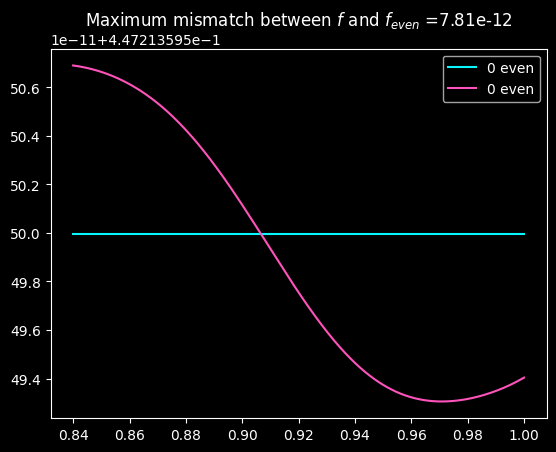

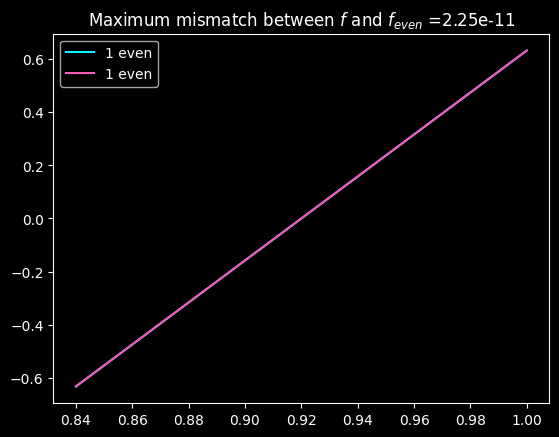

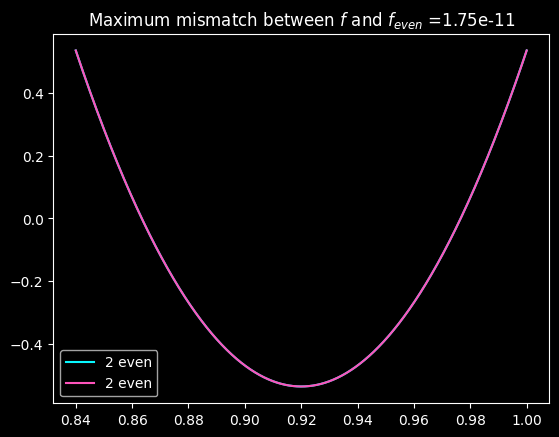

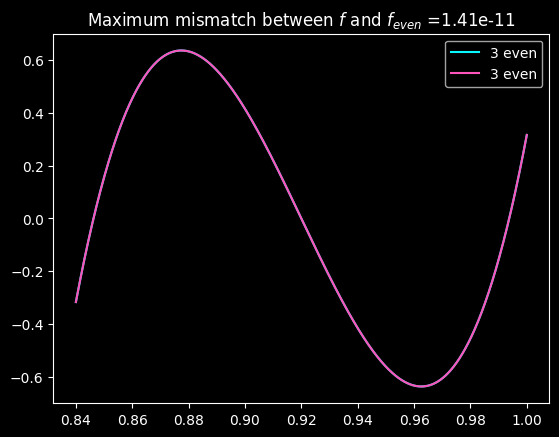

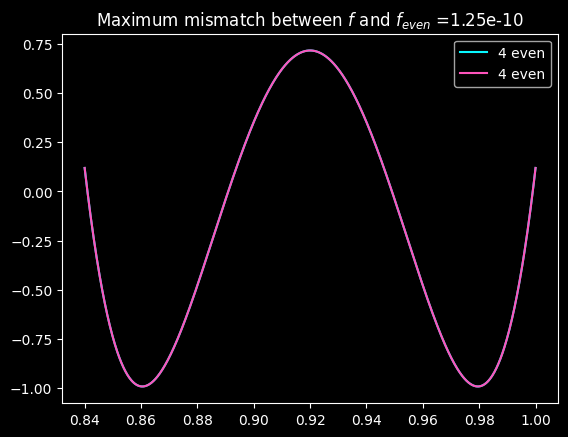

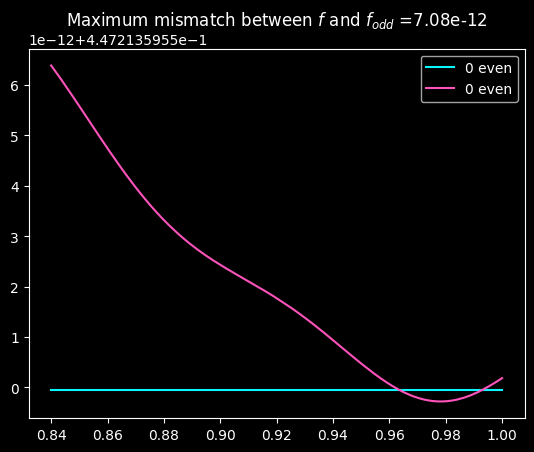

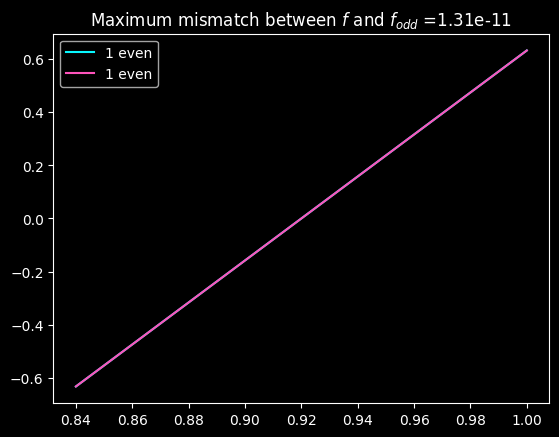

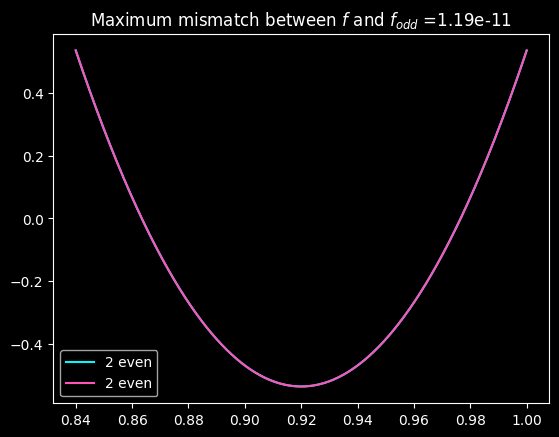

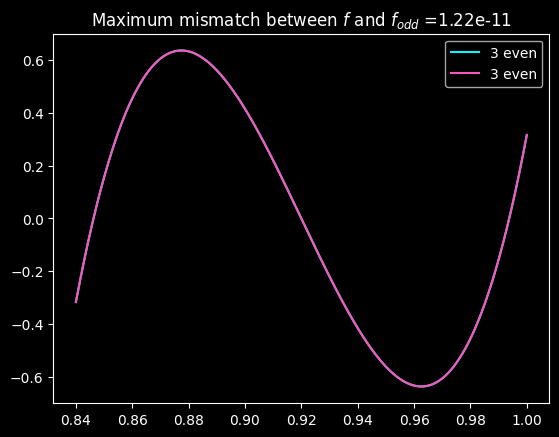

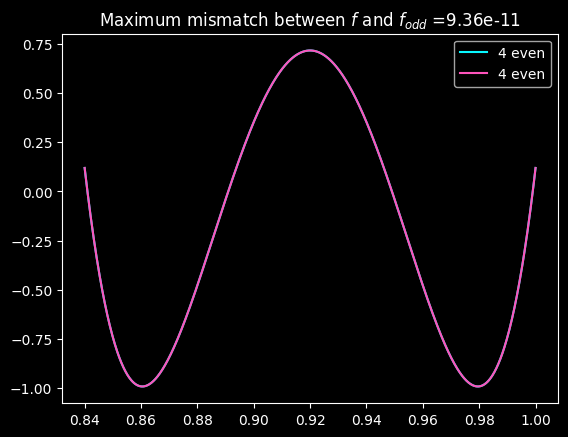

In [39]:
xtest  = mp.linspace(1 - Delta, 1, 900)
r = m
mode = M_EVEN_K
evenerrors = []
for i in range(r):
    yeval = rgs.evaluate_basis(xtest, i)
    frec  = reconstruct_svd_extension(xtest, evencoeffs[i], g, Gamma, Delta, d, mode)
    y = np.array([mp.re(frec[i]) for i in range(len(frec))])
    evenerrors.append(mp.norm(yeval - frec, p = mp.inf))
    plt.title(r"Maximum mismatch between $f$ and $f_{even}$ =" + f"{float(evenerrors[-1]):1.2e}")
    plt.plot(xtest, yeval, label=f"{i} even")
    plt.plot(xtest, y, label=f"{i} even")
    plt.legend()
    plt.show()

mode = M_ODD_K
odderrors = []
for i in range(r):
    yeval = rgs.evaluate_basis(xtest, i)
    frec  = reconstruct_svd_extension(xtest, oddcoeffs[i], g, Gamma, Delta, d, mode)
    y = np.array([mp.re(frec[i]) for i in range(len(frec))])
    odderrors.append(mp.norm(yeval - frec, p = mp.inf))
    plt.title(r"Maximum mismatch between $f$ and $f_{odd}$ =" + f"{float(odderrors[-1]):1.2e}")
    plt.plot(xtest, yeval, label=f"{i} even")
    plt.plot(xtest, y, label=f"{i} even")
    plt.legend()
    plt.show()

Maximum errors (evaluated as maxima over 900 points in the set [1-Delta, 1]) that result from the even and odd continuations of the Gram Polynomials for the parameter values n_Delta = 10, d/Delta = 26/9, g = 63, Gamma = 150. 

In [30]:
for i in range(r):
    print(f"f{i}_even: {evenerrors[i]} f{i}_odd: {odderrors[i]}")

f0_even: 1.424335161863969812120986340434293573133144875043580531637618117e-65 f0_odd: 1.822021902591742612449634826126081473818763224906558805237593663e-25
f1_even: 6.683989984108406681662114867858556189115830596035913619314122771e-24 f1_odd: 4.666276857735980746427709696102053102398735749072366375351204351e-27
f2_even: 4.019514051604980898019380489251735444867791981572113670074050731e-25 f2_odd: 9.848349081680130215072815080626397775057144031641411955978481811e-24
f3_even: 4.217462672820610668186143079554521234407407371898587536111929962e-22 f3_odd: 9.300694082636696064985941914866974663581547818066858033890566165e-25
f4_even: 5.880800748809751833588122352653880019910007191879030349473689826e-23 f4_odd: 6.983754705271000218183799758450298973568402546313128691980583857e-22
f5_even: 0.00000000000000000003488213187117751253877522012967219251021801125875526108642348236 f5_odd: 1.324297036082298734703091218406771653799790058901302850643760371e-22
f6_even: 9.6332043989405632105489219951236

## Compute a Gram-Fourier extension

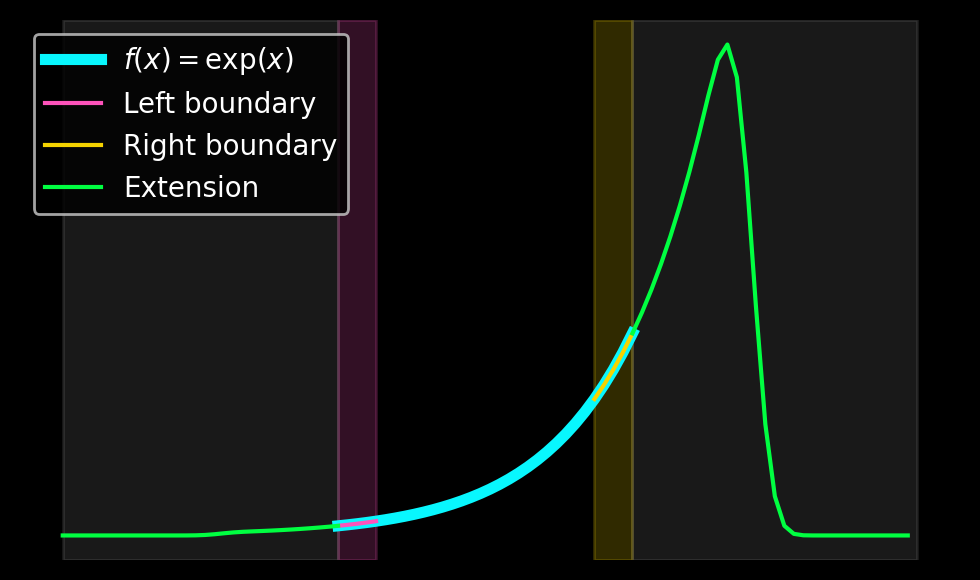

In [246]:
def func(x):
    return np.exp(x)
L   = np.pi
N   = 32
dx  = L/N
x   = np.arange(0, N) * dx
f   = func(x)

# Interpolant at boundaries
f_left   = f[:nDelta]
f_right  = f[-nDelta:]

# Project interpolant at boundaries onto Gram polynomials
a_left   = Pl_numpy @ f_left
a_right  = Pr_numpy @ f_right

# Project interpolant at boundaries onto Gram polynomials
f_left_rec  = a_left @ Pl_numpy
f_right_rec = a_right @ Pr_numpy

f_zero_left  = a_left/2  @ F_even_numpy - a_left/2  @ F_odd_numpy
f_zero_right = a_right/2 @ F_even_numpy + a_right/2 @ F_odd_numpy


f_ext_left  = f_zero_left[:nd+nDelta-1]
f_ext_right = f_zero_right[nDelta-1:-nd+2]

fig, axs = plt.subplots(figsize=(5, 3), dpi=200)

plt.axis("off")
plt.plot(x, f, lw = 4, label=r"$f(x) = \exp(x)$")
plt.plot(x[ :nDelta], f_left_rec, label=r"Left boundary")
plt.axvspan(0, x[nDelta-1], color=colors[1], alpha=0.2)
plt.plot(x[-nDelta:], f_right_rec, label=r"Right boundary")
plt.axvspan(x[-nDelta], x[-1], color=colors[2], alpha=0.2)

plt.plot(np.arange(-len(f_ext_left) + 1, 1) * dx, f_ext_left, c=colors[3], label="Extension")
plt.plot(np.arange(N-1, N - 1 + len(f_ext_right)) * dx, f_ext_right, c=colors[3])
plt.axvspan((-len(f_ext_left) + 1) * dx, 0, color="white", alpha=0.1)
plt.axvspan((N-1) * dx, (N - 1 + len(f_ext_right)) * dx, color="white", alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("figures/gramfe_zero_extension.png", bbox_inches='tight')
plt.show()

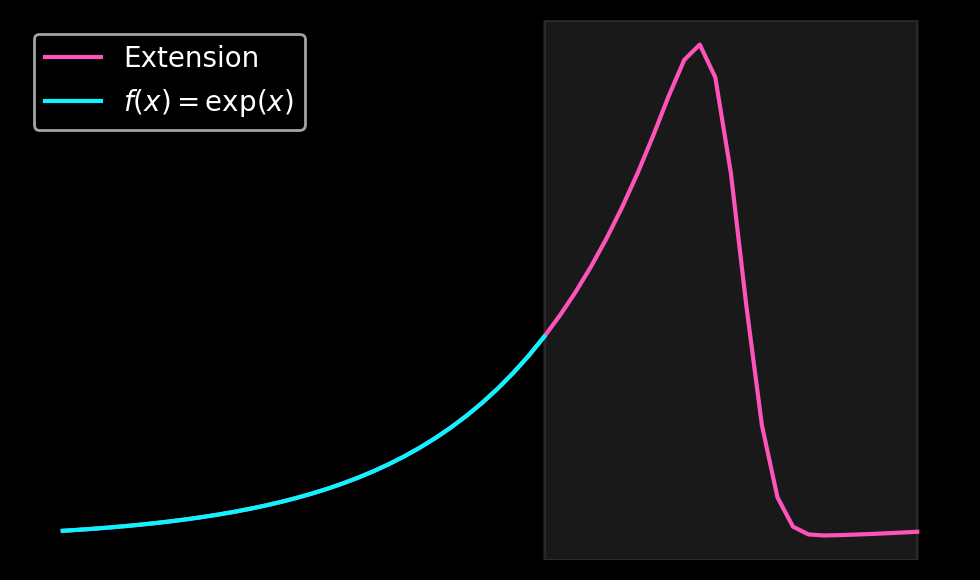

In [248]:

fmatch = (a_left + a_right)/2 @ F_even_numpy + (a_right - a_left)/2 @ F_odd_numpy

f_periodic = np.concatenate([f, fmatch[nDelta:nDelta + nd - 2]])

fig, axs = plt.subplots(figsize=(5, 3), dpi=200)
plt.axis("off")
plt.plot(np.arange(len(f_periodic)) * dx, f_periodic, c=colors[1], label="Extension")
plt.plot(x, f, c=colors[0], label=r"$f(x) = \exp(x)$")
plt.axvspan((N - 1) * dx, (len(f_periodic) - 1) * dx, color="white", alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("figures/gramfe_extension.png", bbox_inches='tight')
plt.show()

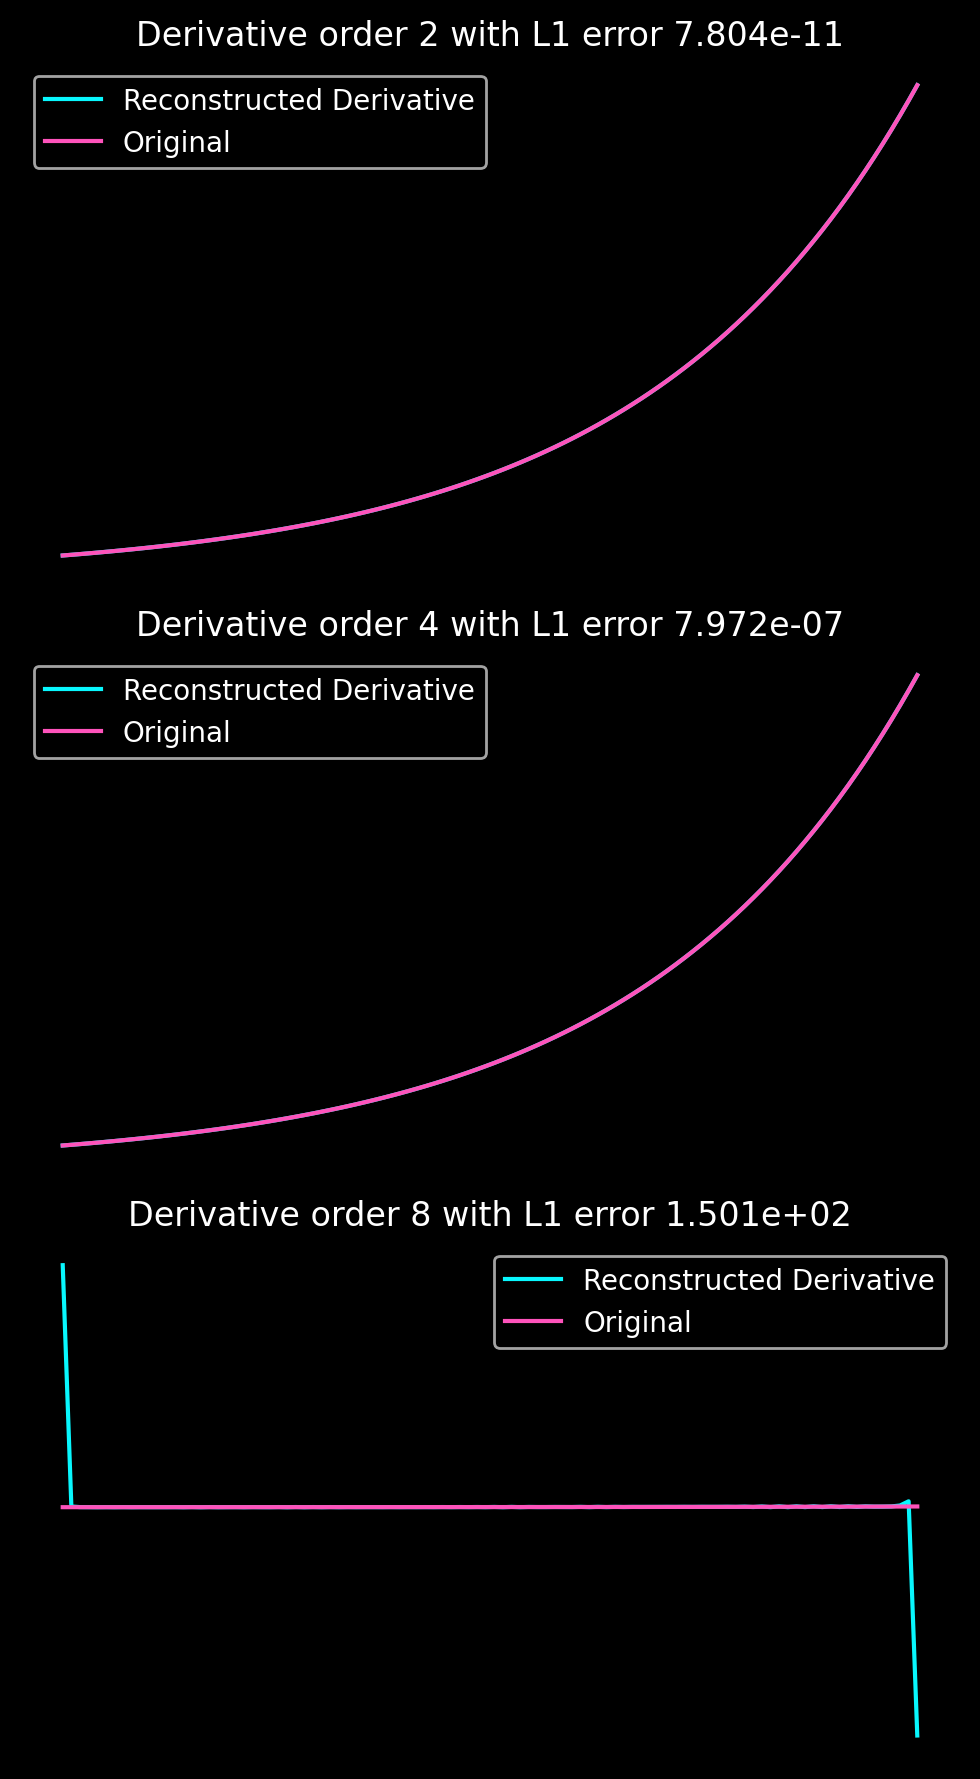

In [17]:

# Number of subplots
num_subplots = 3

# Create subplots
fig, axs = plt.subplots(num_subplots, 1,  figsize=(5 , 3* num_subplots), dpi=200)


def get_k(p, dx):
    """
    Calculate the k values for a given array and spacing.

    Args:
        p (numpy.ndarray): The input array.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The k values.
    """
    N = len(p)
    L = N * dx
    k = 2 * np.pi / L * np.arange(-N / 2, N / 2)
    return np.fft.ifftshift(k)

def func(x):
    return np.exp(x)



L  = np.pi
N  = 100
dx = L/(N - 1)
x  = np.arange(N) * dx

f  = func(x)

# Interpolant at boundaries
f_left   = f[:nDelta]
f_right  = f[-nDelta:]

Gamma = 150
g     = 63
nD    = 14
nd    = 32
nDelta = nD

# Use binary tables with a slightly different format than above
# This should be very easy to adapt to the tables generated above
F = np.fromfile(f"tables/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4)
Fe = F[:nD, :].astype(float)
Fo = F[nD:, :].astype(float)
Pl = np.fromfile(f"tables/Pleft_nD={nD}.bin").reshape( nD, nD).astype(float)
Pr = np.fromfile(f"tables/Pright_nD={nD}.bin").reshape(nD, nD).astype(float)


# Project interpolant at boundaries onto Gram polynomials
a_left   = Pl @ f_left
a_right  = Pr @ f_right

fmatch = (a_left + a_right)/2 @ Fe + (a_right - a_left)/2 @ Fo

f_periodic = np.concatenate([f, fmatch[nDelta:nDelta + nd - 2]])
f_hat = scipy.fft.fft(f_periodic)

# Get the k values
k    = get_k(f_hat, dx)
xorg = x
forg = func(x)

# Loop through different subtraction orders
for i, o in enumerate([2, 4, 8]):
    frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real  # Use only the first N elements (the original domain)
    frec = frec[:N]

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].get_xaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(frec - forg)):3.3e}")
    axs[i].plot(xorg, frec, label="Reconstructed Derivative", c = colors[0])
    axs[i].plot(xorg, forg, label="Original", c = colors[1])
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.savefig("figures/gramfe_accuracy.png", bbox_inches='tight')


/tmp/ipykernel_5574/2133130864.py:45: RuntimeWarning: divide by zero encountered in power
  plt.loglog(k[0:n], np.abs(f_hat[n_start]) * (k[0:n]**n_poly)/(k[n_start]**n_poly), c=colors[i], ls="dotted", label=r"$\propto k^{"+f"{n_poly}"+r"}$")


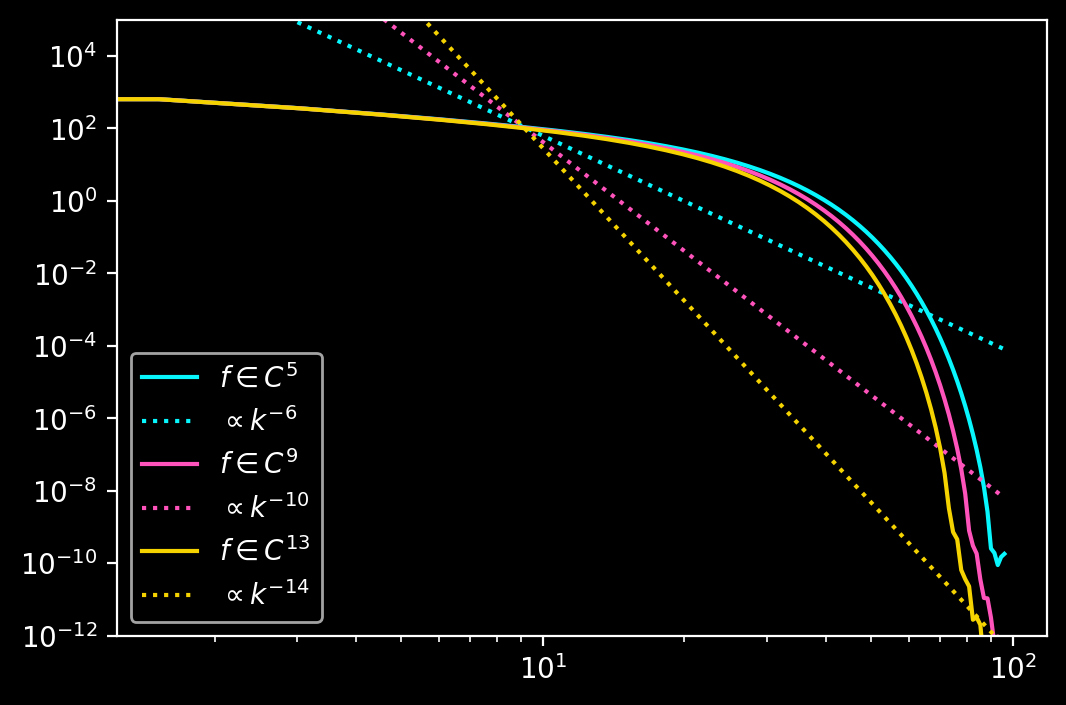

In [16]:
# Configurable parameters
N     = 100 # Size of input domain

# Define the domain and the function
L = np.pi
x = np.linspace(0, L, N)
def func(x):
    return np.exp(x)
f = func(x)
dx = x[1] - x[0]

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
#plt.axis("off")
for i, n_accuracy in enumerate([6, 10, 14]):

    Gamma = 150
    g     = 63
    nD    = n_accuracy
    nd    = 32
    nDelta = nD
    F = np.fromfile(f"tables/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4)
    Fe = F[:nD, :].astype(float)
    Fo = F[nD:, :].astype(float)
    Pl = np.fromfile(f"tables/Pleft_nD={nD}.bin").reshape( nD, nD).astype(float)
    Pr = np.fromfile(f"tables/Pright_nD={nD}.bin").reshape(nD, nD).astype(float)

    # Interpolant at boundaries
    f_left   = f[:nDelta]
    f_right  = f[-nDelta:]

    # Project interpolant at boundaries onto Gram polynomials
    a_left   = Pl @ f_left
    a_right  = Pr @ f_right

    fmatch = (a_left + a_right)/2 @ Fe + (a_right - a_left)/2 @ Fo

    f_periodic = np.concatenate([f, fmatch[nDelta:nDelta + nd - 2]])
    f_hat = scipy.fft.fft(f_periodic)
    # Get the k values
    k = get_k(f_hat, dx)
    n = int(len(f_hat)/2) - 1
    n_start = 6
    n_poly = -n_accuracy
    plt.loglog(k[:n], np.abs(f_hat[:n]), c=colors[i], label = "$f\in C^{" + f"{n_accuracy - 1}" + r"}$")
    plt.loglog(k[0:n], np.abs(f_hat[n_start]) * (k[0:n]**n_poly)/(k[n_start]**n_poly), c=colors[i], ls="dotted", label=r"$\propto k^{"+f"{n_poly}"+r"}$")

plt.legend()
plt.ylim(1e-12, 1e5)
plt.savefig("figures/gramfe_decay.png", bbox_inches='tight')
plt.show()